Submission 2 Kelas Belajar Pengembangan Machine Learning <br>
<b>Membuat Model Machine Learning dengan Data Time Series</b> <br>
menggunakan dataset dari https://www.kaggle.com/jaganadhg/house-hold-energy-data <br>
<hr>
No. Registrasi: 0182180030-11 <br>
Nama: Dian Kurnia Imanda <br>
Email: diankurniaimanda@gmail.com

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import Dense, LSTM, Bidirectional
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df_train = pd.read_csv('D202.csv')
df_train

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN
...,...,...,...,...,...,...,...,...
70363,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00,NaN
70364,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01,NaN
70365,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01,NaN
70366,Electric usage,10/24/2018,23:30,23:44,0.03,kWh,$0.01,NaN


In [3]:
df_train.dropna(axis=1, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
dtypes: float64(1), object(6)
memory usage: 3.8+ MB


In [4]:
# cek apakah ada nilai yang hilang dari dataset 
df_train.isnull().sum()

TYPE          0
DATE          0
START TIME    0
END TIME      0
USAGE         0
UNITS         0
COST          0
dtype: int64

In [5]:
df_train['START'] = pd.to_datetime(df_train['DATE']+ ' '+df_train['START TIME'], format='%m/%d/%Y %H:%M')
df_train['END'] = pd.to_datetime(df_train['DATE']+ ' '+df_train['END TIME'], format='%m/%d/%Y %H:%M')

# in pandas axis=0 represents rows (default) and axis=1 represents columns.
df_train.drop(['TYPE', 'UNITS', 'DATE', 'START TIME', 'END TIME'], axis=1, inplace=True) # Remove the unnecessary

df_train['year'] = df_train.apply(lambda x:x['START'].year, axis=1)
df_train['month'] = df_train.apply(lambda x:x['START'].month, axis=1)
df_train['day'] = df_train.apply(lambda x:x['START'].day, axis=1)
df_train['hour'] = df_train.apply(lambda x:x['START'].hour, axis=1)

df_train['COST'] = df_train['COST'].apply(lambda x:float(x[1:]))

df_train['duration'] = (df_train['END'] - df_train['START'])
df_train

,USAGE,COST,START,END,year,month,day,hour,duration
0,0.01,0.00,2016-10-22 00:00:00,2016-10-22 00:14:00,2016,10,22,0,0 days 00:14:00
1,0.01,0.00,2016-10-22 00:15:00,2016-10-22 00:29:00,2016,10,22,0,0 days 00:14:00
2,0.01,0.00,2016-10-22 00:30:00,2016-10-22 00:44:00,2016,10,22,0,0 days 00:14:00
3,0.01,0.00,2016-10-22 00:45:00,2016-10-22 00:59:00,2016,10,22,0,0 days 00:14:00
4,0.01,0.00,2016-10-22 01:00:00,2016-10-22 01:14:00,2016,10,22,1,0 days 00:14:00
...,...,...,...,...,...,...,...,...,...
70363,0.02,0.00,2018-10-24 22:45:00,2018-10-24 22:59:00,2018,10,24,22,0 days 00:14:00
70364,0.03,0.01,2018-10-24 23:00:00,2018-10-24 23:14:00,2018,10,24,23,0 days 00:14:00
70365,0.03,0.01,2018-10-24 23:15:00,2018-10-24 23:29:00,2018,10,24,23,0 days 00:14:00
70366,0.03,0.01,2018-10-24 23:30:00,2018-10-24 23:44:00,2018,10,24,23,0 days 00:14:00


In [6]:
dates = df_train['START'].values #year
temp  = df_train['USAGE'].values

In [7]:
# bagi data training dan testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(temp, dates, test_size=0.2, random_state=0, shuffle=False)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)


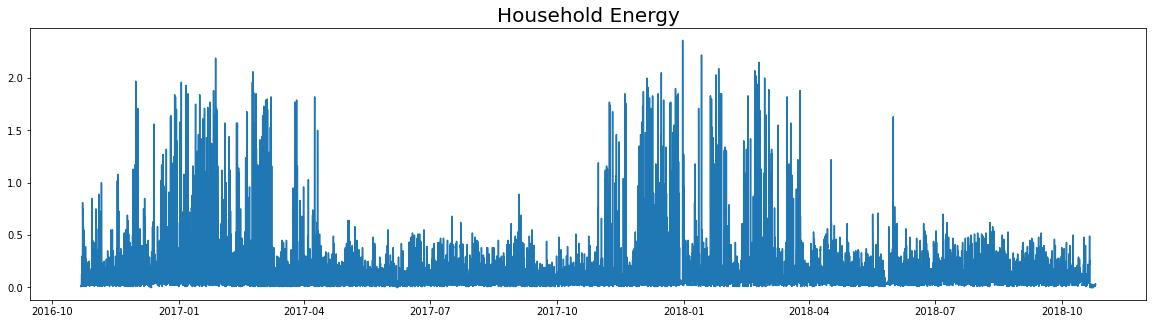

In [8]:
# time series random
plt.figure(figsize=(20,5))
plt.plot(dates, temp)
plt.title('Household Energy',
          fontsize=20);

In [9]:
print(max(temp), min(temp))

2.36 0.0


In [10]:
# menerima sebuah series/atribut yg telah di konversi jadi tipe numpy,
# lalu mengembalikan label dan atribut dari dataset dalam bentuk batch.

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)
#train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)
#val_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=5000)

In [11]:
# arsitektur model

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [12]:
# 10% skala data
max_mae = (max(temp) - min(temp)) * 0.1
print(max_mae) 

class TestCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('mae') < max_mae):
            print('\nMAE kurang dari 10%')
            self.model.stop_training=True
callbacks = TestCallback()

0.236


In [13]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9) # learning rate dan momentum
model.compile(loss=tf.keras.losses.Huber(), # Huber utk time series
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(
    train_set,
    validation_data=val_set,
    #validation_split=0.2,
    epochs=10,
    verbose=2,
    batch_size=16,
    callbacks= [callbacks])

#history = model.fit(train_set, batch_size=16, epochs=100, verbose=2, callbacks= [callbacks])

Epoch 1/10
563/563 - 137s - loss: 0.0289 - mae: 0.1062 - val_loss: 0.0057 - val_mae: 0.0623

MAE kurang dari 10%


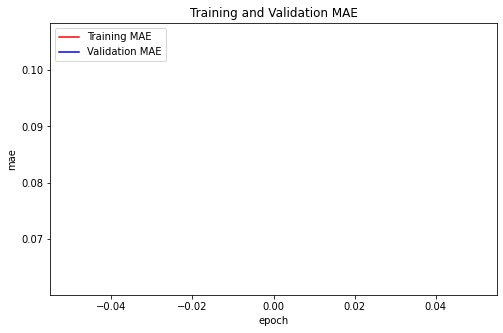

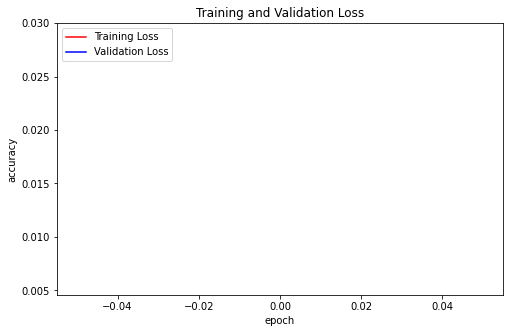

In [14]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(mae))

plt.figure(figsize=(8,5))
plt.plot(epochs_range, mae, 'r', label='Training MAE')
plt.plot(epochs_range, val_mae, 'b', label='Validation MAE')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.title('Training and Validation MAE')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs_range, loss, 'r', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation Loss')
plt.legend(loc='upper left')
plt.show()